In [2]:
from dotenv import load_dotenv
load_dotenv()

from langchain.chat_models import init_chat_model
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph, MessagesState, END
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition, create_react_agent
from langgraph.checkpoint.memory import MemorySaver

from IPython.display import Image, display
from warnings import filterwarnings
filterwarnings("ignore")

USER_AGENT environment variable not set, consider setting it to identify your requests.


**Using meta-llama-3-70b-instruct model**

In [3]:
llm = init_chat_model("mistral-small", model_provider="mistralai")

In [4]:
embeddings = HuggingFaceEmbeddings(model_name = "BAAI/bge-small-en-v1.5")

In [5]:
vector_store = InMemoryVectorStore(embeddings)

**Scrapping data from a webpage using beautiful soup**

In [6]:
# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43130


In [7]:
type(docs[0])

langchain_core.documents.base.Document

In [8]:
docs[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}

In [9]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [10]:
print(len(docs[0].page_content))

43130


Our loaded document is over 43k characters which is too long to fit into the context window of many models. Even for those models that could fit the full post in their context window, models can struggle to find information in very long inputs.

**Chunking the Document**

RecursiveCharacterTextSplitter will recursively split the document using common separators like new lines until each chunk is the appropriate size. This is the recommended text splitter for generic text use cases.

In [11]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,  # chunk size (characters)
    chunk_overlap = 200,  # chunk overlap (characters)
    add_start_index = True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


In [12]:
all_splits[1].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 971}

In [13]:
all_splits[1].page_content

'Memory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model to learn.\nLong-term memory: This provides the agent with the capability to retain and recall (infinite) information over extended periods, often by leveraging an external vector store and fast retrieval.\n\n\nTool use\n\nThe agent learns to call external APIs for extra information that is missing from the model weights (often hard to change after pre-training), including current information, code execution capability, access to proprietary information sources and more.'

In [14]:
all_splits[2].page_content

'Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'

**Indexing**

In [15]:
_ = vector_store.add_documents(documents = all_splits)

In [16]:
len(all_splits) # 66 chunks of document

66

In [17]:
len(_) # Each chuck is stored in an index

66

In [18]:
_[:5]

['5e0d91eb-b7a8-4c9b-b0b4-b94a7f5d13aa',
 '72d733e0-c718-4cfe-bfae-2030f6d90055',
 'cbf3315b-031f-4add-b8fa-e281a00caf80',
 '70fac92d-9a82-4d87-9b52-16808f391265',
 '7c987ac1-2d99-4cf5-9c77-0c8f059029b8']

In [19]:
graph_builder = StateGraph(MessagesState)

In [20]:
@tool(response_format = "content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [21]:
# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

In [22]:
# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])

In [23]:
# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [24]:
graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

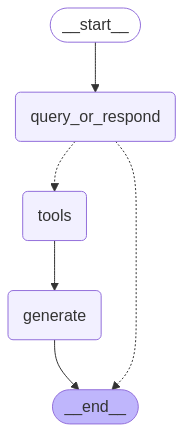

In [25]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today? Is there a specific topic you would like to learn about or discuss? I'm here to answer any questions you have to the best of my ability. I can provide information on a wide variety of subjects, so don't hesitate to ask me anything. I'm here to help.


In [27]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

Task decomposition is the process of breaking down a complex task or project into smaller, manageable components or sub-tasks. This technique is often used in project management, software engineering, and other fields where complex systems or processes need to be designed, built, or managed.

The goal of task decomposition is to make the overall task more manageable, understandable, and tractable. By breaking down a complex task into smaller components, it becomes easier to assign responsibilities, plan resources, estimate timelines, and monitor progress. Additionally, task decomposition can help identify potential bottlenecks, dependencies, and risks, allowing teams to proactively address these issues and ensure successful completion of the project.

Task decomposition typically involves several 

In [28]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "zenai123"}}

In [29]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================

Sure, I can help you with that! However, I need more information about what you are looking to do. Are you interested in finding common ways to do something specific? Here are a few examples to help clarify:

* Common ways to invest money
* Common ways to cook a certain type of food
* Common ways to reduce stress
* Common ways to decorate a room
* Common ways to learn a new language

Could you please provide more context so I can give you a more accurate and helpful response? Thank you!


## Agents

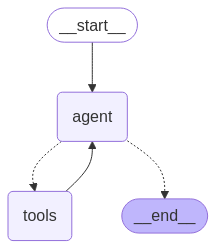

In [30]:
agent_executor = create_react_agent(llm, [retrieve], checkpointer = memory)

display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [31]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================

Task decomposition is the process of breaking down a complex task into smaller, manageable sub-tasks. The standard method for task decomposition typically involves the following steps:

1. Define the task: Clearly define the task that needs to be accomplished, including its objectives and scope.
2. Identify the sub-tasks: Break down the task into smaller sub-tasks that can be accomplished more easily. These sub-tasks should be interdependent and build upon each other to achieve the overall objective of the task.
3. Prioritize the sub-tasks: Determine the order in which the sub-tasks should be accomplished based on their importance, dependencies, and deadlines.
4. Assign resources: Assign the necessary resou

In [35]:
import shutil
import os
shutil.rmtree(os.path.expanduser("~/.cache/huggingface"))